# Building machine-learning models to predict medical costs based on patient characteristics
## author: Dr. Reynier Cruz Torres

## Data source and details:
https://www.kaggle.com/datasets/mirichoi0218/insurance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Numerical data

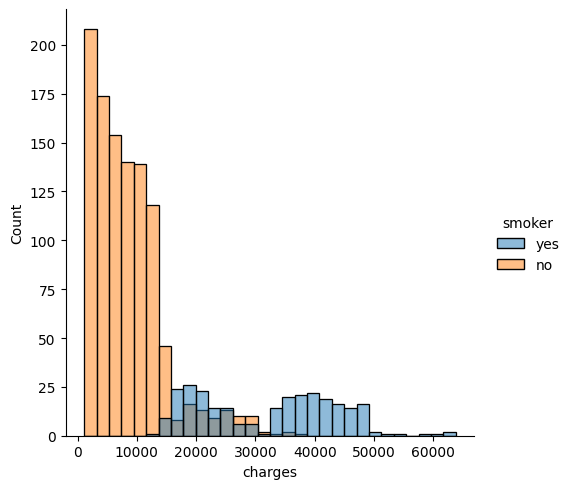

In [6]:
sns.displot(data=df,x='charges',hue='smoker')

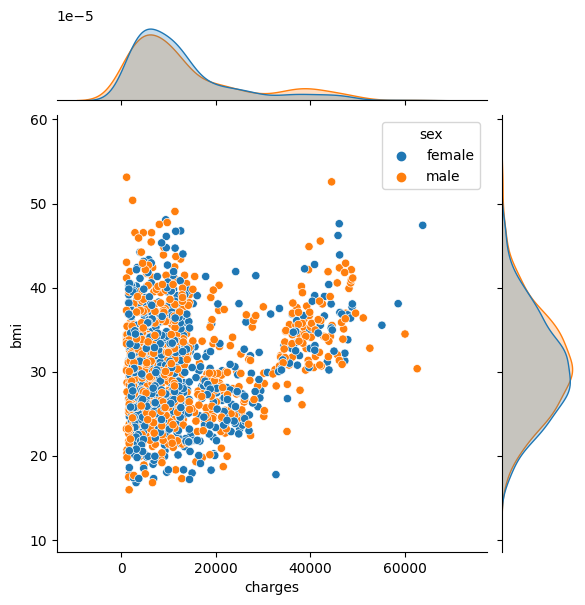

In [7]:
sns.jointplot(data=df,x='charges',y='bmi',hue='sex')

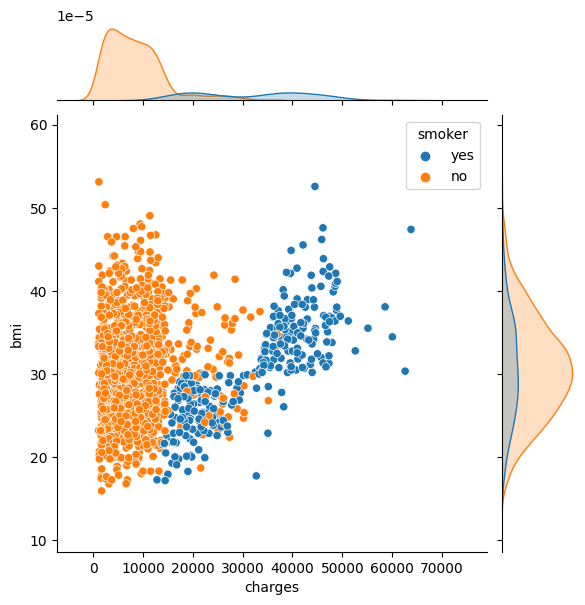

In [8]:
sns.jointplot(data=df,x='charges',y='bmi',hue='smoker')

In [9]:
num_df = df[['age','bmi','children','charges']]
num_df.corr()['charges'][:-1]

age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

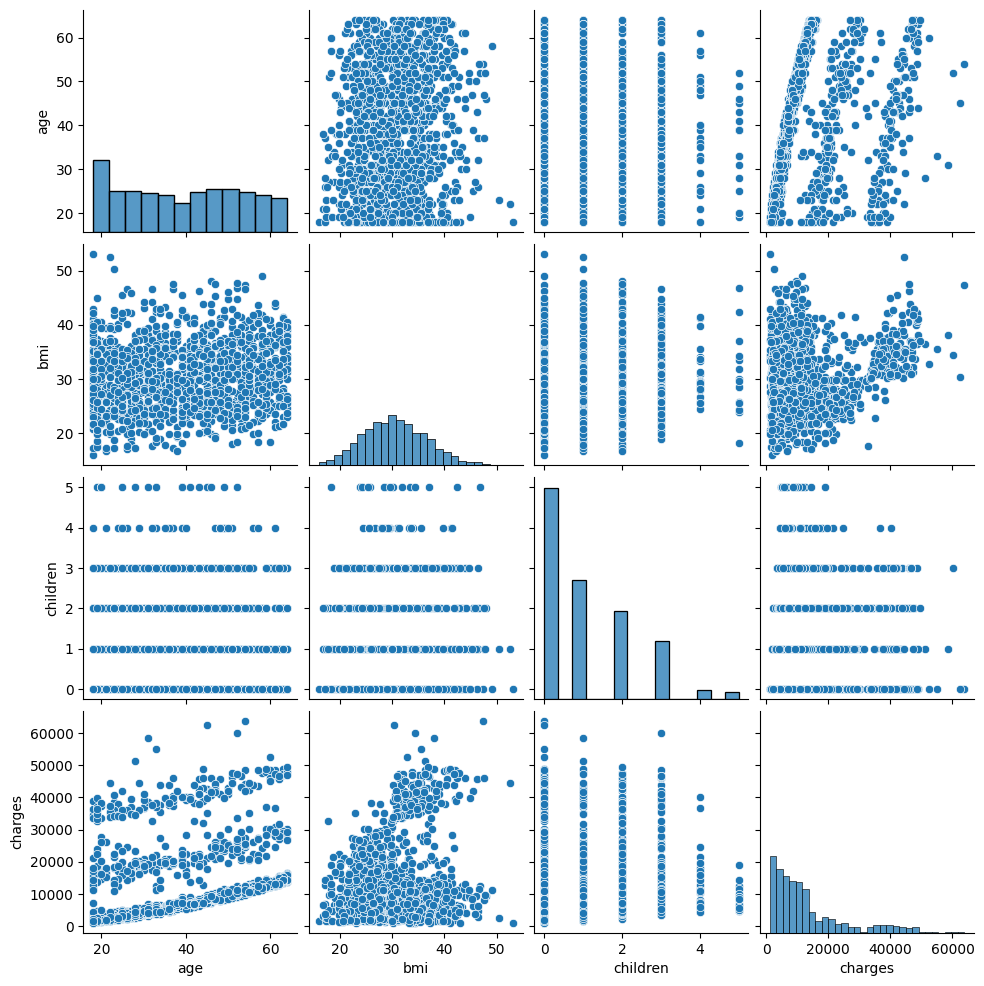

In [10]:
sns.pairplot(num_df)

### Categorical data

In [11]:
df['region'].nunique()

4

In [12]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

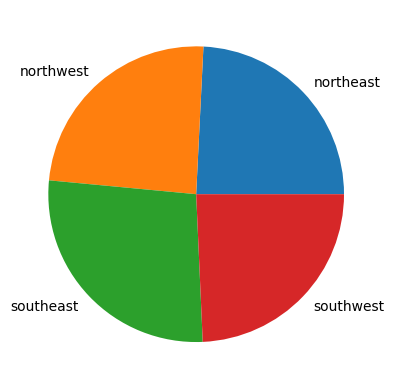

In [13]:
region_freq = df.groupby('region').count()['bmi']
plt.pie(region_freq,labels=region_freq.index)
plt.show()

In [14]:
df = pd.get_dummies(df,columns=['smoker','sex','region'],drop_first=True)
df.head()

,age,bmi,children,charges,smoker_yes,sex_male,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,0,1,0
2,28,33.000,3,4449.46200,0,1,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0


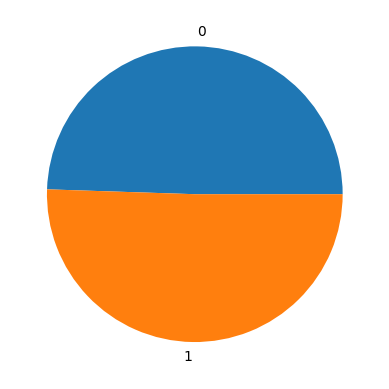

In [15]:
plt.pie(df.groupby('sex_male').count()['charges'],labels=df.groupby('sex_male').count()['charges'].index)
plt.show()

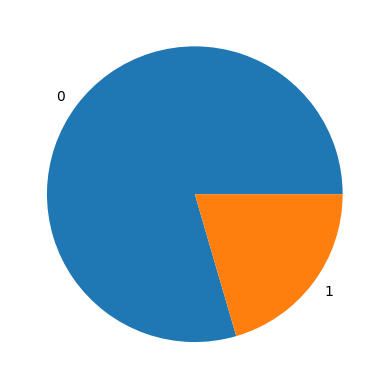

In [16]:
plt.pie(df.groupby('smoker_yes').count()['charges'],labels=df.groupby('smoker_yes').count()['charges'].index)
plt.show()

### Some additional exploratory data analysis

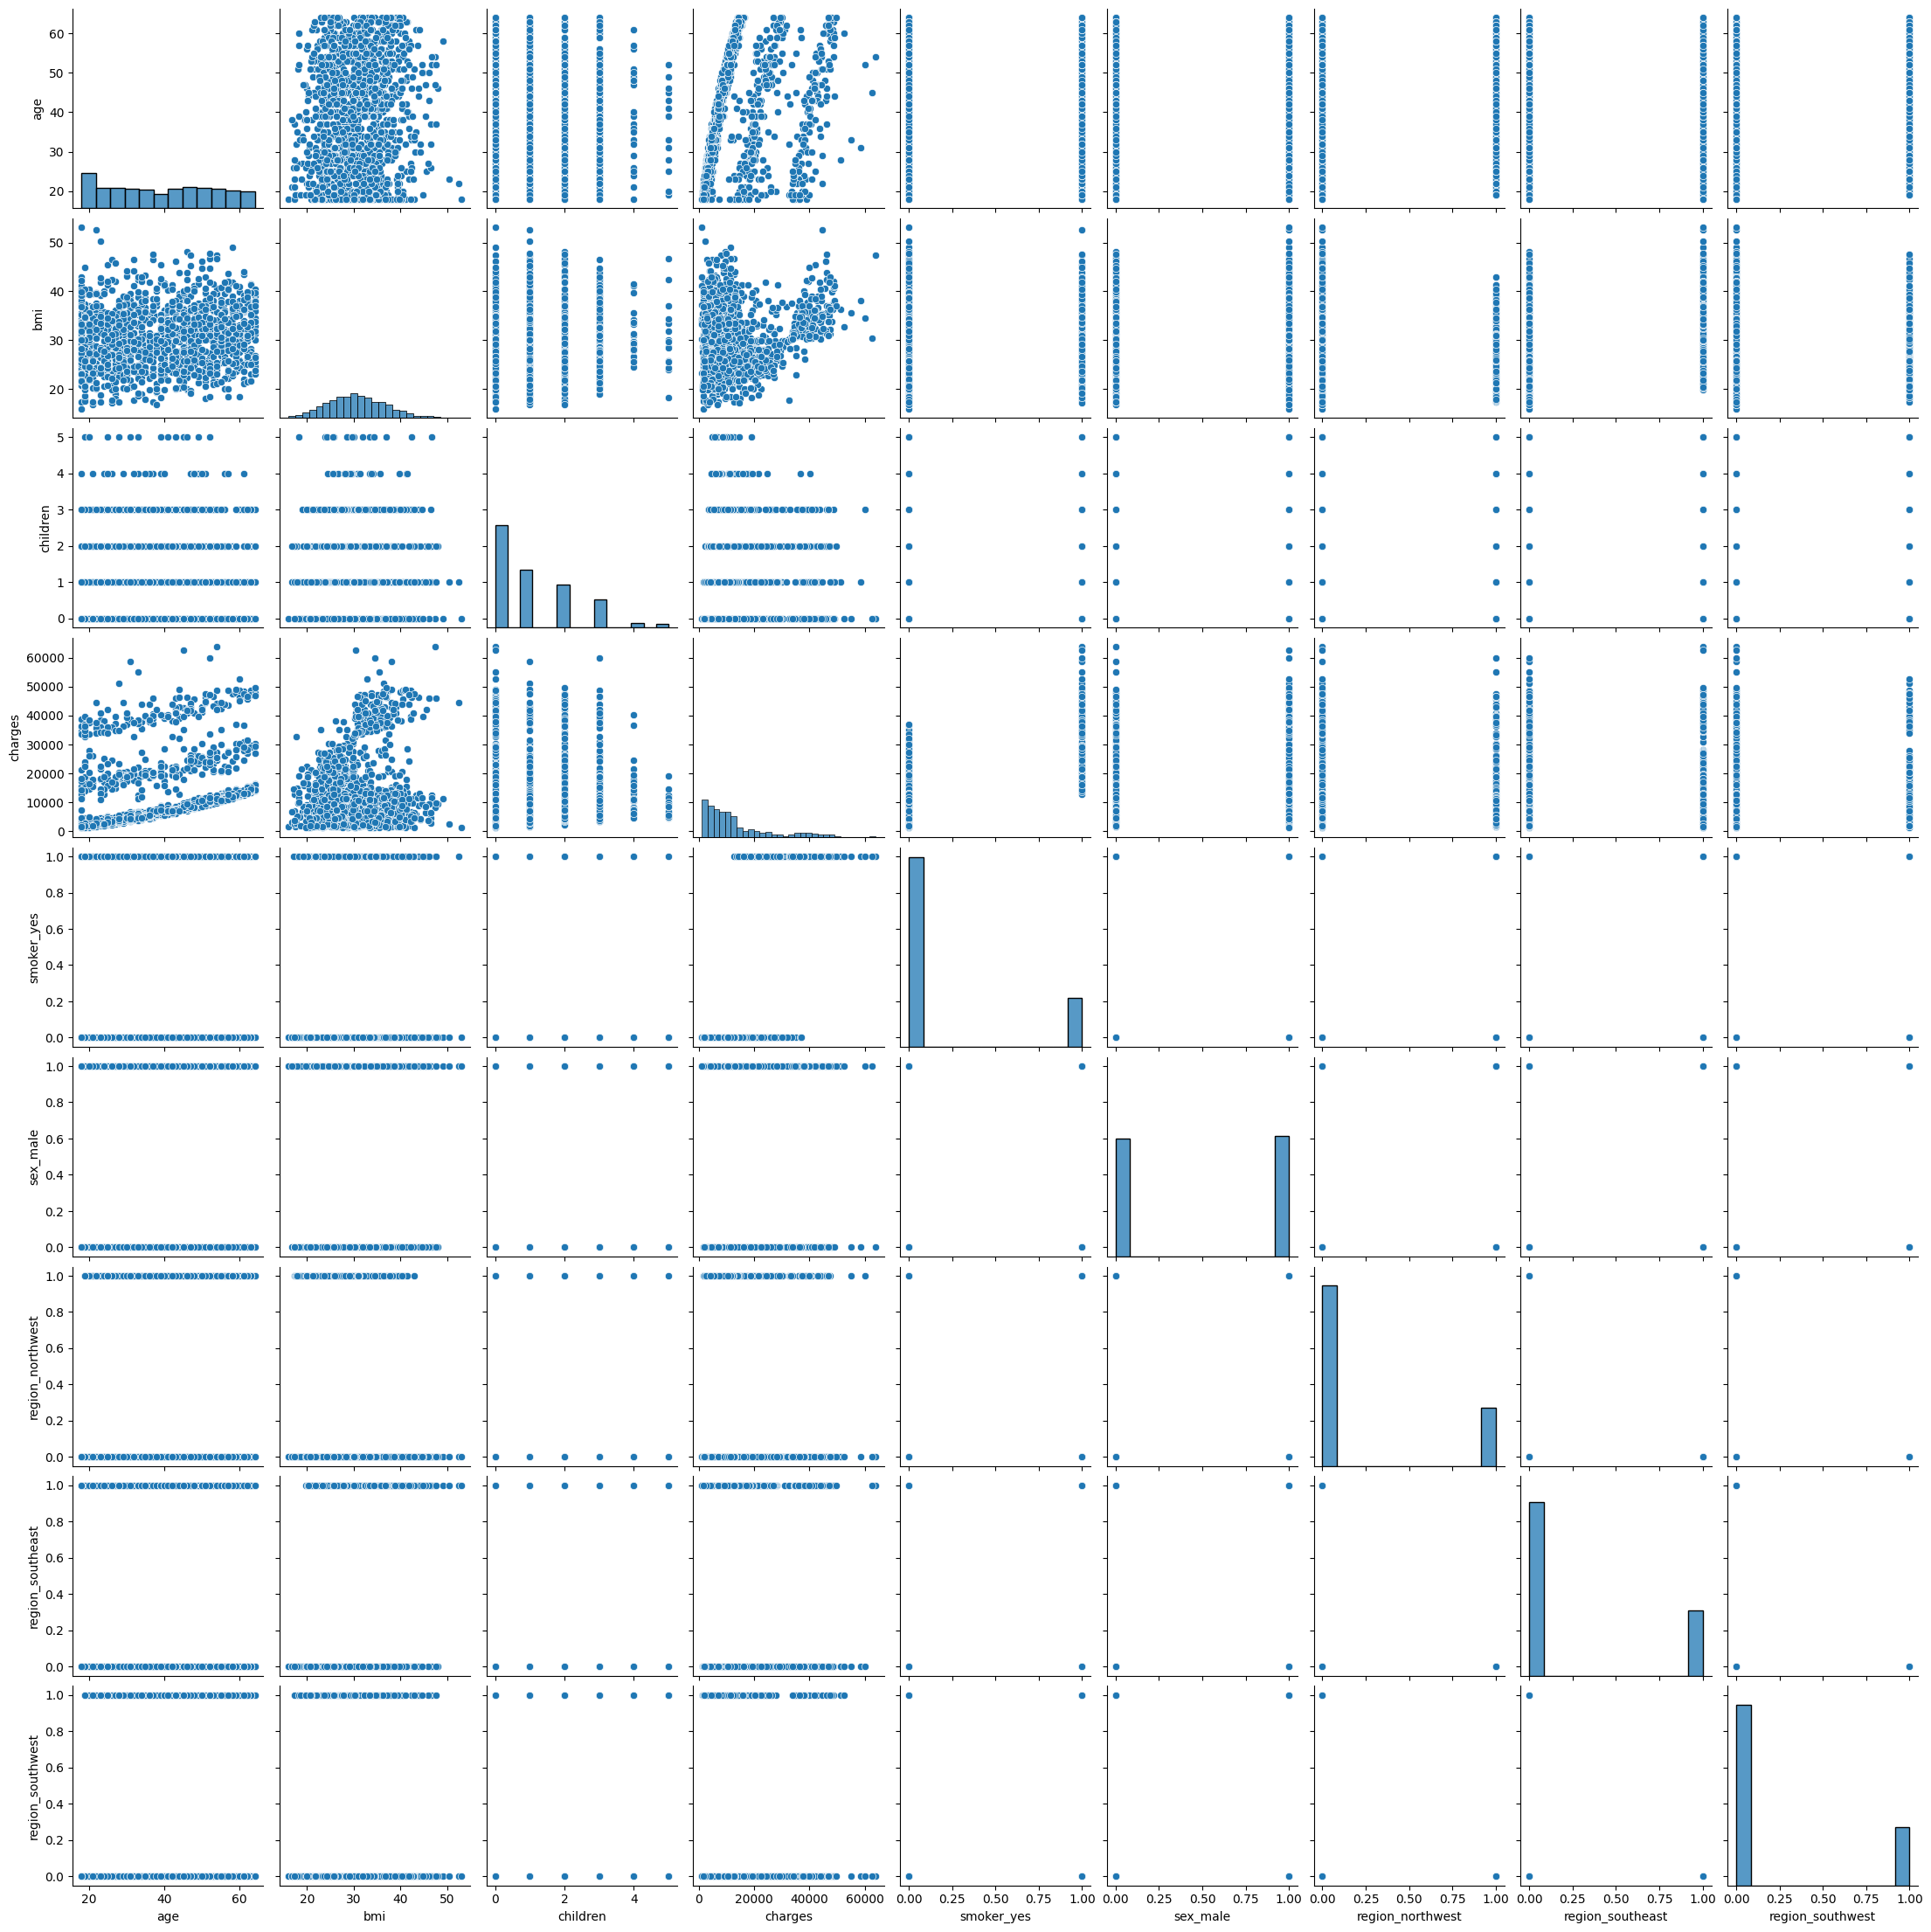

In [17]:
sns.pairplot(df)

In [18]:
df.corr()['charges']

age                 0.299008
bmi                 0.198341
children            0.067998
charges             1.000000
smoker_yes          0.787251
sex_male            0.057292
region_northwest   -0.039905
region_southeast    0.073982
region_southwest   -0.043210
Name: charges, dtype: float64

<AxesSubplot: xlabel='smoker_yes', ylabel='charges'>

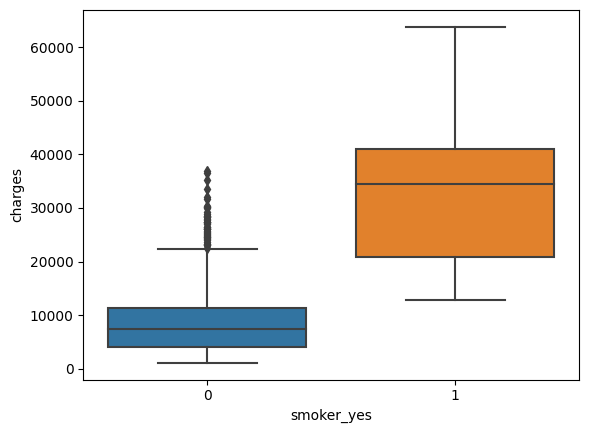

In [19]:
sns.boxplot(data=df,x='smoker_yes',y='charges')

<AxesSubplot: xlabel='sex_male', ylabel='charges'>

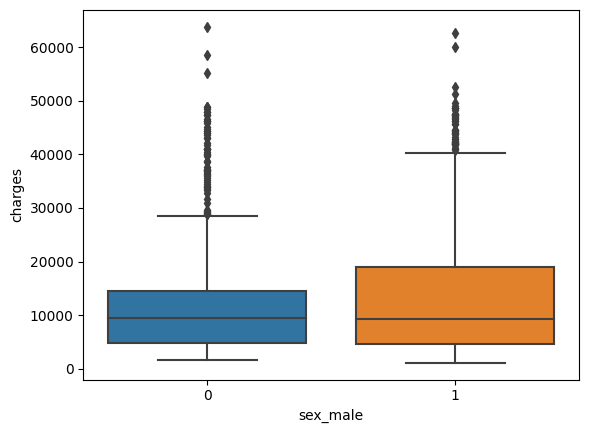

In [20]:
sns.boxplot(data=df,x='sex_male',y='charges')

<AxesSubplot: xlabel='sex_male', ylabel='charges'>

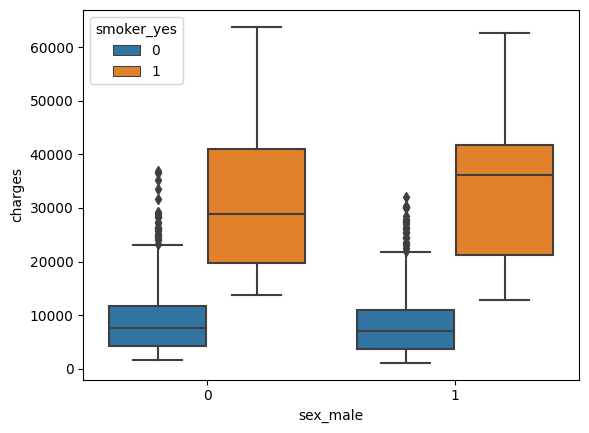

In [21]:
sns.boxplot(data=df,x='sex_male',y='charges',hue='smoker_yes')

## Preparing the data and doing ML modeling

In [22]:
len(df)

1338

In [23]:
from sklearn.model_selection import train_test_split

X = df.drop('charges',axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Modeling

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

def create_train_evaluate(model,X_train,y_train,X_test,y_test,param_grid,label='model'):
    
    t0 = time.time()
    
    # Train model
    gs = GridSearchCV(model,param_grid=param_grid,cv=5)
    gs.fit(X_train,y_train)
    
    t = (time.time()-t0)/60.
    
    # Evaluate model
    preds = gs.predict(scaled_X_test)

    print('mean absolute error',mean_absolute_error(y_test,preds))
    print('root mean squared error',np.sqrt(mean_squared_error(y_test,preds)))
    print('Best estimator',gs.best_estimator_)
    print('Best params',gs.best_params_)
    
    print('Training took',np.round(t,2),'min')
        
    return gs, np.sqrt(mean_squared_error(y_test,preds))

### Linear Regression

In [26]:
from sklearn.linear_model import ElasticNet
param_grid = {'alpha':[0.01,0.05,0.1,0.15,0.2,0.3],'l1_ratio':[0.8,00.85,0.9,0.95,1.0],'max_iter':[1000,2000]}

linr, linr_rmse = create_train_evaluate(ElasticNet(),scaled_X_train,y_train,
                                       scaled_X_test,y_test,param_grid,'Elastic Net')

mean absolute error 4173.062368337733
root mean squared error 5806.032224444825
Best estimator ElasticNet(alpha=0.01, l1_ratio=0.85)
Best params {'alpha': 0.01, 'l1_ratio': 0.85, 'max_iter': 1000}
Training took 0.0 min


### K-Nearest Neighbors

In [27]:
from sklearn.neighbors import KNeighborsRegressor
param_grid = {'n_neighbors':[3,5,7],'leaf_size':[20,30,40]}

knn, knn_rmse = create_train_evaluate(KNeighborsRegressor(),scaled_X_train,y_train,
                                       scaled_X_test,y_test,param_grid,'KNN')

mean absolute error 3599.650978541045
root mean squared error 5763.684802052312
Best estimator KNeighborsRegressor(leaf_size=20)
Best params {'leaf_size': 20, 'n_neighbors': 5}
Training took 0.0 min


### Support Vector Machine

In [28]:
from sklearn.svm import SVR
param_grid = {'C':[2.0,3.0,4.0],'degree':[2,3],'epsilon':[0.05,0.1,0.2],'tol':[0.0005,0.001,0.005,0.01]}

svm, svm_rmse = create_train_evaluate(SVR(),scaled_X_train,y_train,
                                      scaled_X_test,y_test,param_grid,'SVM')

mean absolute error 8533.191103059527
root mean squared error 12802.068368882448
Best estimator SVR(C=4.0, degree=2, epsilon=0.05, tol=0.0005)
Best params {'C': 4.0, 'degree': 2, 'epsilon': 0.05, 'tol': 0.0005}
Training took 0.12 min


### Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {'n_estimators':[100,120,130,140],'max_features':[0.3,0.4,0.5,0.6]}
    
rfor, rfor_rmse = create_train_evaluate(RandomForestRegressor(),scaled_X_train,y_train,
                                        scaled_X_test,y_test,param_grid,'Random Forest')

mean absolute error 2619.132469222781
root mean squared error 4609.930944735765
Best estimator RandomForestRegressor(max_features=0.4, n_estimators=130)
Best params {'max_features': 0.4, 'n_estimators': 130}
Training took 0.13 min


### Boosted decision trees

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'learning_rate':[0.035,0.04,0.045,0.05],'n_estimators':[80,85,90,95,100]}

boostedt, boostedt_rmse = create_train_evaluate(GradientBoostingRegressor(),scaled_X_train,y_train,
                                        scaled_X_test,y_test,param_grid,'Boosted tree')

mean absolute error 2542.5824091206105
root mean squared error 4376.204245805474
Best estimator GradientBoostingRegressor(learning_rate=0.04, n_estimators=90)
Best params {'learning_rate': 0.04, 'n_estimators': 90}
Training took 0.06 min


### Feed-forward NN

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(8,'relu'))
model.add(Dropout(0.5))
model.add(Dense(6,'relu'))
model.add(Dense(4,'relu'))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

early_stop = EarlyStopping(patience=5)

t0 = time.time()

model.fit(x=scaled_X_train,y=y_train,epochs=90,verbose=0,batch_size=1,
          validation_data=(scaled_X_test,y_test),callbacks=[early_stop])

t = (time.time()-t0)/60.
print('Training took',np.round(t,2),'min')

2023-01-09 16:21:37.536363: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Training took 0.27 min


Text(0, 0.5, 'loss')

<Figure size 640x480 with 0 Axes>

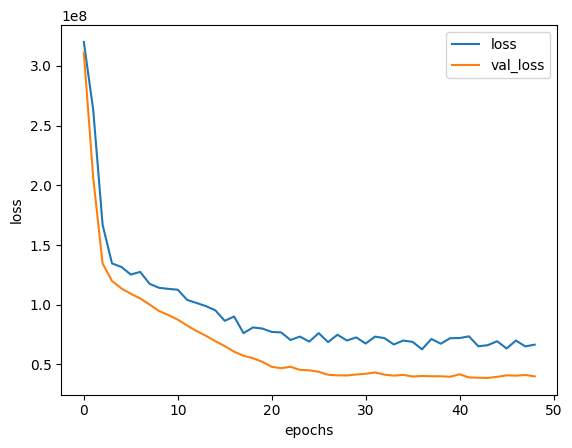

In [32]:
plt.figure()
history = pd.DataFrame(model.history.history)
history.plot()
plt.xlabel('epochs')
plt.ylabel('loss')

In [33]:
preds = model.predict(scaled_X_test)
nn_rmse = np.sqrt(mean_squared_error(y_test,preds))

9/9 [==============================] - 0s 705us/step


### Comparing model performances

Text(0, 0.5, 'root mean squared error')

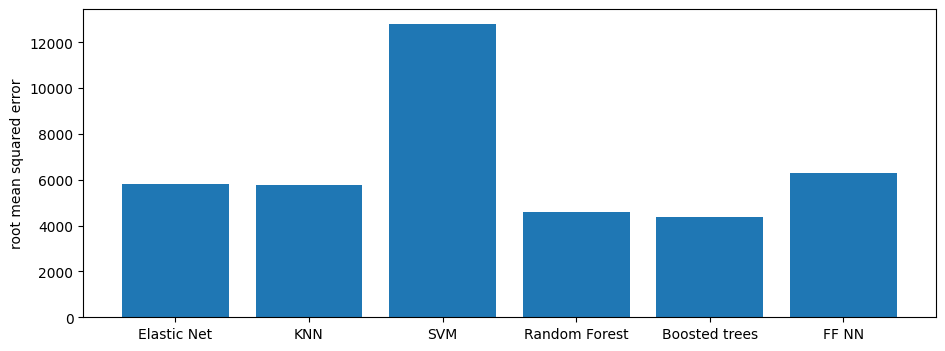

In [34]:
plt.figure(figsize=(11,4))
labels = ['Elastic Net','KNN', 'SVM', 'Random Forest', 'Boosted trees','FF NN']
rmse = [linr_rmse,knn_rmse,svm_rmse,rfor_rmse,boostedt_rmse,nn_rmse]
plt.bar(x=labels,height=rmse)
plt.ylabel('root mean squared error')

Text(0.5, 0, 'expected value')

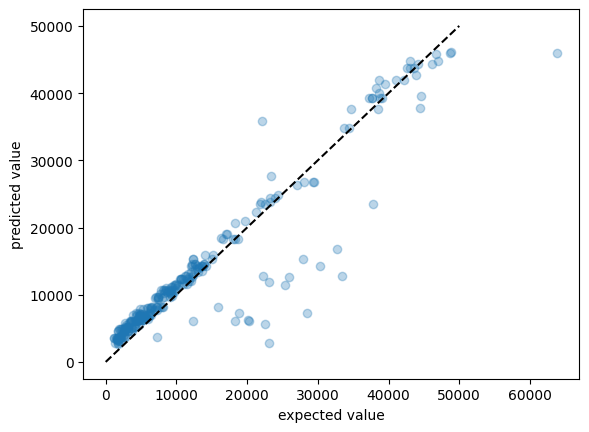

In [35]:
preds = boostedt.predict(scaled_X_test)
plt.scatter(y_test,preds,alpha=0.3)
plt.plot([0,50000],[0,50000],ls='--',color='black',label='Boosted trees')
plt.ylabel('predicted value')
plt.xlabel('expected value')